This unit runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

## Working with data
PyTorch has two primitives to work with data: ``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``. ``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around the ``Dataset``.


In [1]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

PyTorch offers domain-specific libraries such as `TorchText`, `TorchVision`, and `TorchAudio`, all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like CIFAR and COCO. In this tutorial, we'll use the **FashionMNIST** dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and ``target_transform`` to modify the samples and labels respectively.

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=  ToTensor()
)



We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.



Shape of X [N,C,H,W]: torch.Size([64, 1, 28, 28]) torch.float32
Shape of y: torch.Size([64]) torch.int64


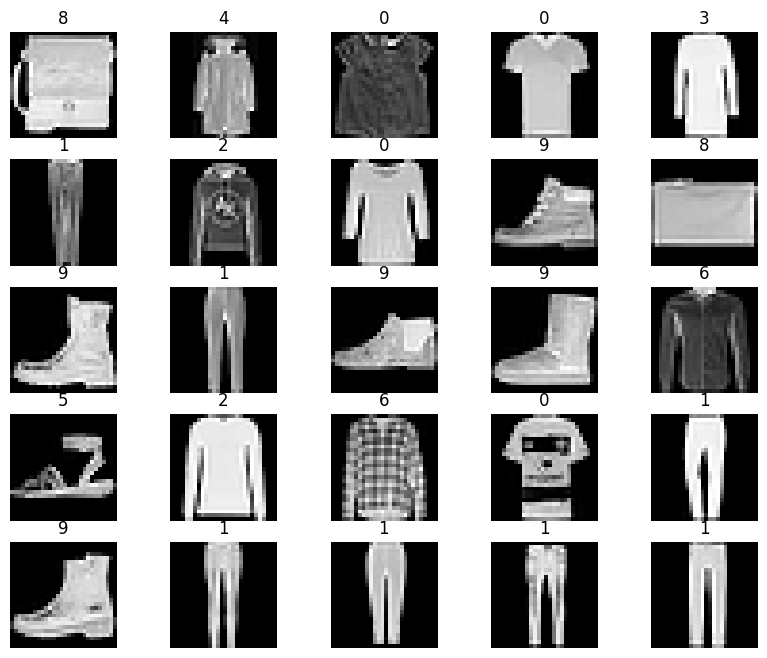

In [10]:
batch_size=64


train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X,y in test_dataloader:
    print("Shape of X [N,C,H,W]:", X.shape, X.dtype)
    print("Shape of y:", y.shape, y.dtype)
    break


figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Creating models
To define a neural network in PyTorch, we create a class that inherits from `nn.Module`. We define the layers of the network in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate operations in the neural network, we move it to the GPU if available.



In [11]:
device="cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [12]:
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10),
            nn.ReLU()
        )
    
    def forward(self,x):
        x=self.flatten(x)
        logits=self.linear_relu_stack(x)
        return logits
    

model=NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


## Optimizing the Model Parameters
To train a model, we need a loss function and an optimizer.  We'll be using `nn.CrossEntropyLoss` for loss and `Stochastic Gradient Descent` for optimization.

In [13]:
loss_fn=nn.CrossEntropyLoss()
learning_rate=1e-3
optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and back-propagates the prediction error to adjust the model's parameters. 



In [14]:
def train(dataloader,model,loss_fn,optimizer):
    size=len(dataloader.dataset)
    
    for batch,(X,y) in enumerate (dataloader):
        X,y=X.to(device),y.to(device)
        
        pred=model(X)
        loss=loss_fn(pred,y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss,current = loss.item(),batch*len(X)
            print(f'Loss:{loss:>7f} [{current:>5d}/{size:>5d}]')

In [17]:
def test(dataloader,model):
    size=len(dataloader.dataset)
    model.eval()
    test_loss,correct=0,0
    
    with torch.no_grad():
        for X,y in dataloader:
            X,y=X.to(device),y.to(device)
            pred=model(X)
            test_loss+=loss_fn(pred,y).item()
            correct+=(pred.argmax(1)==y).type(torch.float).sum().item()
            
    test_loss/=size
    correct/=size
    print(f'Test Error:\n Accuracy:{100*correct:>0.1f}%, Avg loss:{test_loss:>8f}\n')
    

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the accuracy increase and the loss decrease with every epoch.



In [18]:
epochs=20

for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------------')
    train(train_dataloader,model,loss_fn,optimizer)
    test(test_dataloader,model)
print('Done!')

Epoch 1
-------------------------------
Loss:2.243749 [    0/60000]
Loss:2.226989 [ 6400/60000]
Loss:2.184601 [12800/60000]
Loss:2.182703 [19200/60000]
Loss:2.148045 [25600/60000]
Loss:2.118972 [32000/60000]
Loss:2.163214 [38400/60000]
Loss:2.097820 [44800/60000]
Loss:2.115945 [51200/60000]
Loss:2.099849 [57600/60000]
Test Error:
 Accuracy:45.8%, Avg loss:0.032354

Epoch 2
-------------------------------
Loss:2.102556 [    0/60000]
Loss:2.077865 [ 6400/60000]
Loss:1.989376 [12800/60000]
Loss:2.020309 [19200/60000]
Loss:1.919364 [25600/60000]
Loss:1.882440 [32000/60000]
Loss:1.972951 [38400/60000]
Loss:1.840993 [44800/60000]
Loss:1.891083 [51200/60000]
Loss:1.881004 [57600/60000]
Test Error:
 Accuracy:49.8%, Avg loss:0.028168

Epoch 3
-------------------------------
Loss:1.843735 [    0/60000]
Loss:1.815517 [ 6400/60000]
Loss:1.649721 [12800/60000]
Loss:1.766994 [19200/60000]
Loss:1.612246 [25600/60000]
Loss:1.582497 [32000/60000]
Loss:1.742245 [38400/60000]
Loss:1.556808 [44800/60000]


In [19]:
torch.save(model.state_dict(),'Full Build.pth')
print('Saved PyTorch Model State to Full Build.pth')

Saved PyTorch Model State to Full Build.pth


In [20]:
model=NeuralNetwork()
model.load_state_dict(torch.load('Full Build.pth'))

<All keys matched successfully>

In [22]:
classes=[
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

model.eval()
    

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)

In [23]:
x,y=test_data[0][0],test_data[0][1]
with torch.no_grad():
    pred=model(x)
    predicted,actual=classes[pred[0].argmax(0)],classes[y]
    print(f'Predicted:{predicted}, Actual:{actual}')


Predicted:Ankle boot, Actual:Ankle boot
